In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
from random import choice,shuffle
from scipy import stats as st

from collections import deque

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


# Importer des données

Les données que j'utilise sont des images générées par ordinateur de mains montrant les différentes poses des ciseaux à papier de pierre. L'ensemble de données "rock paper ciseaux" est disponible directement à partir du package Tensorflow.

In [ ]:
import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteXGXR12/rock_paper_scissors-train.tfrecord


  0%|          | 0/2520 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteXGXR12/rock_paper_scissors-test.tfrecord


  0%|          | 0/372 [00:00<?, ? examples/s]

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


# Visualiser les données

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


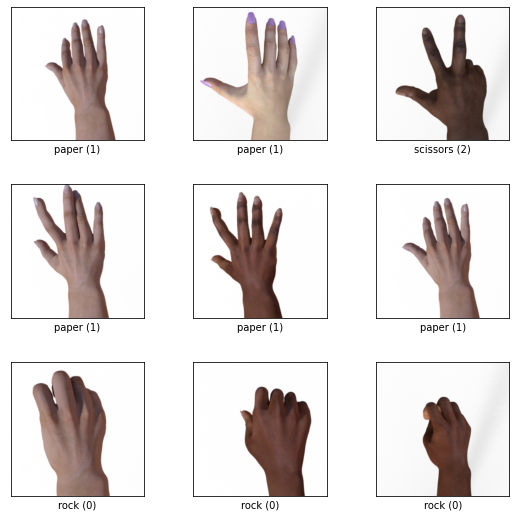

In [ ]:
fig = tfds.show_examples(ds_info, ds_train)
classes = np.array(['rock', 'paper', 'scissors'])

# Pré-traitement

Même si les images sont recadrées, je dois toujours mettre à l'échelle les images et les pré-traiter avant de pouvoir les utiliser comme entrée appropriée pour mon modèles.

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


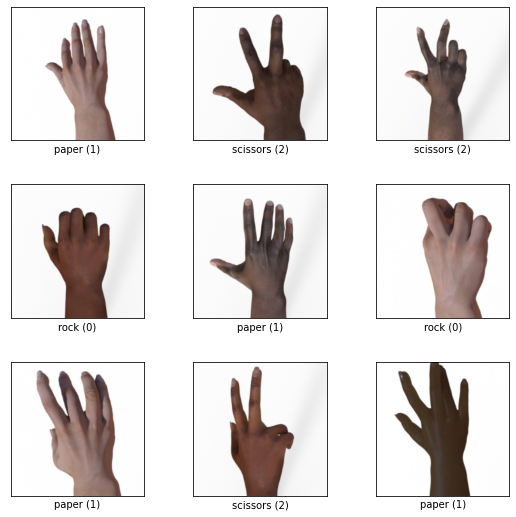

In [ ]:
#remodelage de l'image
INPUT_IMG_SIZE = 224
INPUT_IMG_SHAPE = (224, 224, 3)
#pré-traitement de l'image d'entrée
def preprocess_image(sample):
    sample['image'] = tf.cast(sample['image'], tf.float32)
    sample['image'] = sample['image'] / 255.
    sample['image'] = tf.image.resize(sample['image'], [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return sample
#mapping
ds_train = ds_train.map(preprocess_image)
ds_test  = ds_test.map(preprocess_image)
#sample data 
fig = tfds.show_examples(ds_info, ds_train)

### Convertir au format numpy

In [ ]:
train_numpy = np.vstack(tfds.as_numpy(ds_train))
test_numpy = np.vstack(tfds.as_numpy(ds_test))

X_train = np.array(list(map(lambda x: x[0]['image'], train_numpy)))
y_train = np.array(list(map(lambda x: x[0]['label'], train_numpy)))

X_test = np.array(list(map(lambda x: x[0]['image'], test_numpy)))
y_test = np.array(list(map(lambda x: x[0]['label'], test_numpy)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


# Télécharger un échantillon de test personnalisé

Saving scissors.png to scissors.png
User uploaded file "scissors.png" with length 89166 bytes


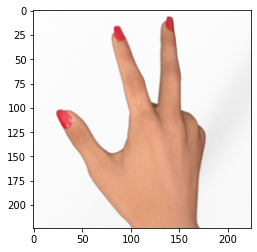

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
from PIL import Image
 
# Modifiez le nom du fichier ici si nécessaire
filename = 'scissors.png'
 
# pre-process image
image = Image.open(filename).convert('RGB')
image_resized = image.resize((INPUT_IMG_SIZE, INPUT_IMG_SIZE), Image.BICUBIC)
test_sample = np.array(image_resized)/255.0
test_sample = test_sample.reshape(1, INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3)

import seaborn as sns

plt.figure(figsize=(4,4));
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3));

# Classification avec MobileNetV2

j'ai utilisé MobileNetV2, qui est spécialement conçu pour être petit et rapide (il peut donc fonctionner sur des appareils mobiles ). Les MobileNets sont disponibles en différentes tailles et entraînés pour différentes tailles d'images d'entrée. J'utilise la taille d'image d'entrée 224x224.

In [ ]:
import sys
sys.getsizeof(tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE
))

14548992/14536120 [==============================] - 0s 0us/step


64

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE
)
#résumé du modèle de base
base_model.summary()
#utiliser le mode de base pour prédire notre image personnalisée 
base_probs = base_model.predict(test_sample)
base_probs.shape
url = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_classes = np.array(open(url).read().splitlines())[1:]
imagenet_classes.shape

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

(1000,)

###  les 5 premières classes prédites pour mon image de test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


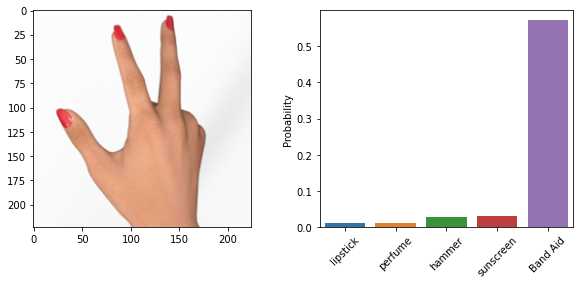

In [ ]:

most_likely_classes = np.argsort(base_probs.squeeze())[-5:]
plt.figure(figsize=(10,4));

plt.subplot(1,2,1)
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3));

plt.subplot(1,2,2)
p = sns.barplot(imagenet_classes[most_likely_classes],base_probs.squeeze()[most_likely_classes]);
plt.ylabel("Probability");
p.set_xticklabels(p.get_xticklabels(), rotation=45);

MobileNetV2 est formé à une tâche spécifique : classer les images dans l'ensemble de données ImageNet en sélectionnant la plus appropriée des 1000 étiquettes de classe. Il n'est pas formé pour la tâche spécifique : classer une image d'une main comme pierre, papier ou ciseaux. En conséquence, j'obtiens une classification abrupte qui est loin du résultat souhaité. je dois donc affiner le modèle de base pour obtenir des prédictions dans la plage souhaitée.

# Contexte | Paufiné un modèle 

Un réseau de neurones convolutifs, prend en compte de nombreuses couches entre l'entrée et la sortie

Nous avons une séquence de couches convolutives suivies de couches de mise en commun. Ces couches sont des extracteurs de caractéristiques qui « apprennent » les caractéristiques clés de nos images d'entrée.
Ensuite, nous avons une ou plusieurs couches entièrement connectées suivies d'une couche entièrement connectée avec une fonction d'activation softmax. Cette partie du réseau est destinée à la classification .
L'idée clé derrière l'apprentissage par transfert est que la partie extracteur de caractéristiques du réseau peut être réutilisée dans différentes tâches et différents domaines.
Ceci est particulièrement utile lorsque nous n'avons pas beaucoup de données spécifiques à une tâche. Nous pouvons obtenir un extracteur de caractéristiques pré-entraîné entraîné sur un grand nombre de données d'une autre tâche, puis entraîner le classificateur sur des données spécifiques à la tâche.
Le processus général est :
- Obtenez un modèle pré-entraîné, sans la couche de classification.
- Gelez le modèle de base.
- Ajoutez une couche de classification.
- Entraînez le modèle (seuls les poids de votre couche de classification seront mis à jour).
- (Facultatif) Dégelez certaines des dernières couches de notre modèle de base.
- (Facultatif) Entraînez à nouveau le modèle, avec un taux d'apprentissage plus faible.

# Former le modèle MobilnetV2 
### Sans la couche entièrement connectée au sommet du réseau.


Je ne veut pas utiliser la couche de classification supérieure du modèle MobileNetV2 pré-entraîné car il contient 1000 classes alors que j'en ai besoin que de 3 ( rock, paper et scissors). je spécifie cela en définissant un include_top paramètre sur False.


In [ ]:
import tensorflow.keras.backend as K
K.clear_session()
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE,
  include_top=False, 
  pooling='avg'
)
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

Je gèle le modèle. Je n'entraine pas la partie MobileNetV2 du modèle, Je l'utilise simplement pour extraire des caractéristiques des images.
Je créer un nouveau modèle à partir de la "tête" du MobileNetV2 déjà installé, avec une toute nouvelle tête de classification totalement inexpérimentée sur le dessus :

In [ ]:
# Geler le modèle de base car je ne veux pas le ré-entraîner.
# Je veux extraire seulement les caractéristiques 
base_model.trainable = False
model = tf.keras.models.Sequential()

model.add(base_model)

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(
    units=3,
    activation=tf.keras.activations.softmax
))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


# Compilation et data augmentation

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
BATCH_SIZE=256

from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
train_generator = train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE)

val_gen = ImageDataGenerator()
val_generator = val_gen.flow(X_test, y_test, batch_size=BATCH_SIZE)

# Entrainement du modèle

### Sans mettre à jour les poids du modèle

In [ ]:
%%time
n_epochs = 20

hist = model.fit(
    train_generator, 
    epochs=n_epochs,
    steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
    validation_data=val_generator, 
    validation_steps=X_test.shape[0]//BATCH_SIZE
)

Epoch 1/20
9/9 [==============================] - 32s 3s/step - loss: 1.4023 - accuracy: 0.4236 - val_loss: 0.9538 - val_accuracy: 0.5039
Epoch 2/20
9/9 [==============================] - 24s 3s/step - loss: 0.8497 - accuracy: 0.6148 - val_loss: 0.5389 - val_accuracy: 0.8867
Epoch 3/20
9/9 [==============================] - 24s 3s/step - loss: 0.5320 - accuracy: 0.7853 - val_loss: 0.5303 - val_accuracy: 0.8008
Epoch 4/20
9/9 [==============================] - 24s 3s/step - loss: 0.3529 - accuracy: 0.8746 - val_loss: 0.3674 - val_accuracy: 0.9062
Epoch 5/20
9/9 [==============================] - 24s 3s/step - loss: 0.2947 - accuracy: 0.8922 - val_loss: 0.3128 - val_accuracy: 0.8945
Epoch 6/20
9/9 [==============================] - 24s 3s/step - loss: 0.2114 - accuracy: 0.9390 - val_loss: 0.3656 - val_accuracy: 0.8320
Epoch 7/20
9/9 [==============================] - 24s 3s/step - loss: 0.1806 - accuracy: 0.9431 - val_loss: 0.2711 - val_accuracy: 0.9219
Epoch 8/20
9/9 [==================

# Performance du modèle

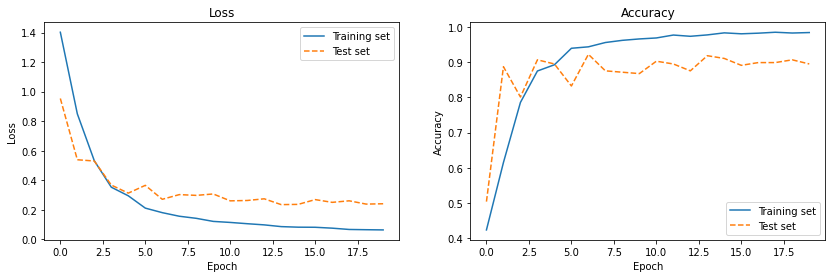

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.legend()

plt.show()

In [ ]:
model.evaluate(train_generator,batch_size=32)

10/10 [==============================] - 26s 3s/step - loss: 0.0284 - accuracy: 0.9976


[0.028422316536307335, 0.9976190328598022]

In [ ]:
model.evaluate(val_generator,batch_size=32)

2/2 [==============================] - 1s 311ms/step - loss: 0.2253 - accuracy: 0.9140


[0.22529251873493195, 0.9139785170555115]

# Modèle affiné

Nous avons installé notre propre tête de classification, mais il reste une étape à franchir pour essayer de personnaliser le modèle pour notre application particulière.
Nous allons "dégeler" les dernières parties du modèle et l'entraîner pour quelques époques supplémentaires sur nos données, afin qu'il soit mieux adapté à notre tâche de classification spécifique.
Notez que nous ne créons pas un nouveau modèle. Nous allons simplement continuer à entraîner le modèle que nous avons déjà commencé à entraîner.


In [ ]:
# Dégeler les couches supérieur du modèle
base_model.trainable = True
len(base_model.layers)
fine_tune_at = 149

# geler les premières couches avant la couche finetune
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# utiliser un taux d'entraînement plus petit pour le réglage fin
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
    optimizer = opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 723,843
Non-trainable params: 1,537,984
_________________________________________________________________


In [ ]:
%%time
n_epochs_fine = 10

hist_fine = model.fit( 
    train_generator, 
    epochs=n_epochs + n_epochs_fine,
    initial_epoch=n_epochs,  
    steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
    validation_data=val_generator, 
    validation_steps=X_test.shape[0]//BATCH_SIZE
)

Epoch 21/30
9/9 [==============================] - 30s 3s/step - loss: 0.0339 - accuracy: 0.9931 - val_loss: 0.2434 - val_accuracy: 0.8906
Epoch 22/30
9/9 [==============================] - 24s 3s/step - loss: 0.0275 - accuracy: 0.9951 - val_loss: 0.2428 - val_accuracy: 0.8906
Epoch 23/30
9/9 [==============================] - 24s 3s/step - loss: 0.0217 - accuracy: 0.9947 - val_loss: 0.2715 - val_accuracy: 0.8789
Epoch 24/30
9/9 [==============================] - 23s 3s/step - loss: 0.0173 - accuracy: 0.9965 - val_loss: 0.2275 - val_accuracy: 0.9141
Epoch 25/30
9/9 [==============================] - 24s 3s/step - loss: 0.0161 - accuracy: 0.9973 - val_loss: 0.2514 - val_accuracy: 0.8984
Epoch 26/30
9/9 [==============================] - 24s 3s/step - loss: 0.0131 - accuracy: 0.9978 - val_loss: 0.2464 - val_accuracy: 0.9023
Epoch 27/30
9/9 [==============================] - 24s 3s/step - loss: 0.0170 - accuracy: 0.9943 - val_loss: 0.2512 - val_accuracy: 0.8828
Epoch 28/30
9/9 [==========

# Performance du modèle

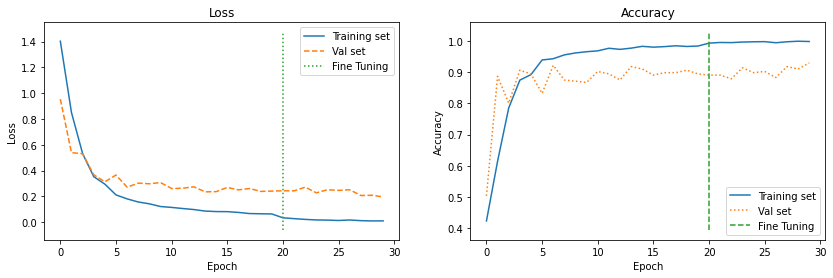

In [ ]:

loss = hist.history['loss'] + hist_fine.history['loss']
val_loss = hist.history['val_loss'] + hist_fine.history['val_loss']

accuracy = hist.history['accuracy'] + hist_fine.history['accuracy']
val_accuracy = hist.history['val_accuracy'] + hist_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Val set', linestyle='--')
plt.plot([n_epochs, n_epochs], plt.ylim(),label='Fine Tuning',linestyle='dotted')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Val set', linestyle='dotted')
plt.plot([n_epochs, n_epochs], plt.ylim(), label='Fine Tuning', linestyle='--')
plt.legend()

plt.show()

In [ ]:
model.evaluate(train_generator,batch_size=32)

10/10 [==============================] - 26s 3s/step - loss: 0.0179 - accuracy: 0.9984


[0.017907723784446716, 0.9984126687049866]

In [1]:
model.evaluate(test_generator,batch_size=32)

NameError: ignored

# Matrice de confusion sur le jeu de train

In [ ]:
y_predict_train = np.argmax(model.predict(X_train), axis=-1)

In [ ]:
cm = confusion_matrix(y_train, y_predict_train, normalize='true')

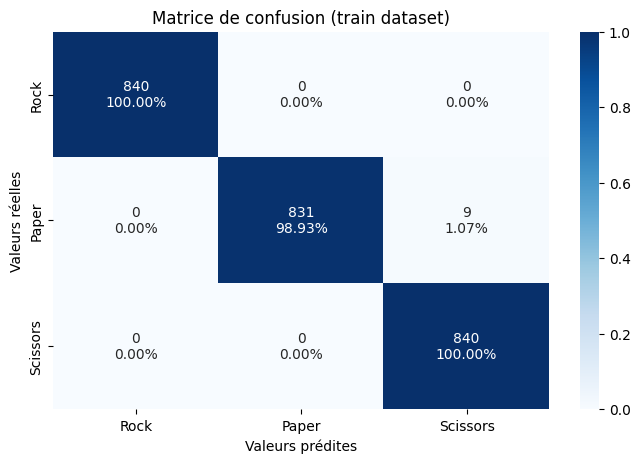

In [ ]:
counts = ["{0:0.0f}\n".format(value) for value in confusion_matrix(y_train, y_predict_train, normalize=None).flatten()]
percentages = ["{0:.2%}".format(value) for value in confusion_matrix(y_train, y_predict_train, normalize='true').flatten()]

box_labels = [f"{v1}{v2}" for v1, v2 in zip(counts, percentages)]
box_labels = np.asarray(box_labels).reshape(cm.shape[0],cm.shape[1])

plt.figure(figsize=(8,5), dpi=100)

plt.title("Matrice de confusion (train dataset)")

sns.heatmap(cm,
            vmin=0.0,
            vmax=1.0,
            cmap='Blues',
            annot=box_labels,
            fmt='',
            xticklabels=["Rock", "Paper", "Scissors"],
            yticklabels=["Rock", "Paper", "Scissors"])

plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

plt.show()

# Matrice de confusion sur le jeu de test

In [ ]:
y_predict_test = np.argmax(model.predict(X_test), axis=-1)

In [ ]:
cm = confusion_matrix(y_test, y_predict_test, normalize='true')

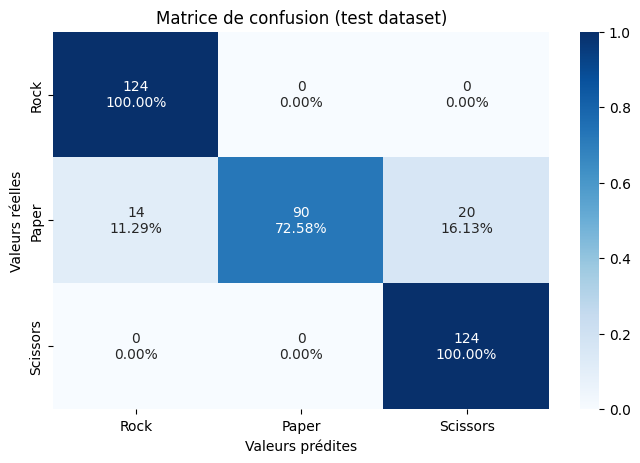

In [ ]:
counts = ["{0:0.0f}\n".format(value) for value in confusion_matrix(y_test, y_predict_test, normalize=None).flatten()]
percentages = ["{0:.2%}".format(value) for value in confusion_matrix(y_test, y_predict_test, normalize='true').flatten()]

box_labels = [f"{v1}{v2}" for v1, v2 in zip(counts, percentages)]
box_labels = np.asarray(box_labels).reshape(cm.shape[0],cm.shape[1])

plt.figure(figsize=(8,5), dpi=100)

plt.title("Matrice de confusion (test dataset)")

sns.heatmap(cm,
            vmin=0.0,
            vmax=1.0,
            cmap='Blues',
            annot=box_labels,
            fmt='',
            xticklabels=["Rock", "Paper", "Scissors"],
            yticklabels=["Rock", "Paper", "Scissors"])

plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

plt.show()

# Classer l'échantillon de test personnalisé

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


CPU times: user 111 ms, sys: 2.07 ms, total: 113 ms
Wall time: 116 ms


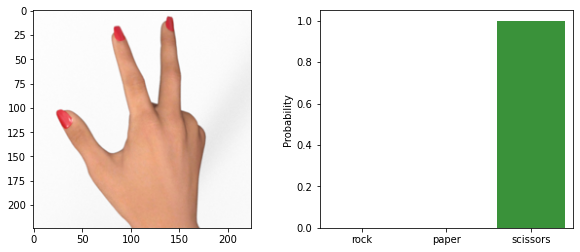

In [ ]:
%%time
test_probs = model.predict(test_sample)
plt.figure(figsize=(10,4));

plt.subplot(1,2,1)
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3));

plt.subplot(1,2,2)
p = sns.barplot(classes,test_probs.squeeze());
plt.ylabel("Probability");

# Enregistrer le modèle

In [ ]:
from keras import models
model.save("rps.h5")

# Charger le modèle

In [ ]:
model = models.load_model("rps.h5")

# Ajout de la fonctionnalité

Tout d'abord, j'ai besoin d'une fonction qui prend deux mouvements, un par l'utilisateur et un par l'ordinateur, puis découvre qui a gagné ce tour.

In [ ]:
def findout_winner(user_move, Computer_move):
  # All logic below is self explanatory
  if user_move == Computer_move:
    return "Tie"
  elif user_move == "rock" and Computer_move == "scissor":
    return "User"
  elif user_move == "rock" and Computer_move == "paper":
    return "Computer"
  elif user_move == "scissor" and Computer_move == "rock":
    return "Computer"
  elif user_move == "scissor" and Computer_move == "paper":
    return "User"
  elif user_move == "paper" and Computer_move == "rock":
    return "User"
  elif user_move == "paper" and Computer_move == "scissor":
    return "Computer"

## Tester cette fonction.

In [ ]:
user_move = 'paper'
computer_move = choice(['rock', 'paper', 'scissor'])

winner = findout_winner(user_move, computer_move)

print("L'utilisateur a sélectionné '{}' et l'ordinateur a sélectionné '{}' , le gagnat est : '{}' ".format(user_move, computer_move, winner))

Voici une autre fonction qui décidera du gagnant en comptant le score de l'utilisateur et celui de l'ordinateur.

In [ ]:
def show_winner(user_socre, computer_score):
  if user_score > computer_score:
    img = cv2.imread("images/youwin.jpg")
  elif user_score < computer_score:
    img = cv2.imread("images/comwins.jpg")
  else:
    img = cv2.imread("images/draw.jpg")
  cv2.putText(img, "Press 'ENTER' to play again, else exit",
              (150, 530), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
  cv2.imshow("Rock Paper Scissors", img)

  # If enter is pressed.
  k = cv2.waitKey(0)
  
  # If the user presses 'ENTER' key then return TRUE, otherwise FALSE
  if k == 13:
    return True
    
  else:
    return False

Enfin, cette fonction affichera une image de pierre, de papier ou de ciseaux en fonction du mouvement joué par l'ordinateur.

In [ ]:
def display_computer_move(computer_move_name, frame):
    
    icon = cv2.imread( "images/{}.png".format(computer_move_name), 1)
    icon = cv2.resize(icon, (224,224))
    
    # This is the portion which we are going to replace with the icon image
    roi = frame[0:224, 0:224]

    # Get binary mask from the transparent image, 4th channel is the alpha channel 
    mask = icon[:,:,-1] 

    # Making the mask completely binary (black & white)
    mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]

    # Store the normal bgr image
    icon_bgr = icon[:,:,:3] 
    
    # Now combine the foreground of the icon with background of ROI 
    
    img1_bg = cv2.bitwise_and(roi, roi, mask = cv2.bitwise_not(mask))

    img2_fg = cv2.bitwise_and(icon_bgr, icon_bgr, mask = mask)

    combined = cv2.add(img1_bg, img2_fg)

    frame[0:224, 0:224] = combined

    return frame

# Flux vidéo

In [ ]:
cap = cv2.VideoCapture(1)
box_size = 234
width = int(cap.get(3))

# Specify the number of attempts you want. This means best of 5.
attempts = 5

# Initially the moves will be `nothing`
computer_move_name= "nothing"
final_user_move = "nothing"

label_names = ['nothing', 'paper', 'rock', 'scissor']

# All scores are 0 at the start.
computer_score, user_score = 0, 0

# The default color of bounding box is Blue
rect_color = (255, 0, 0)

# This variables remembers if the hand is inside the box or not.
hand_inside = False

# At each iteration we will decrease the total_attempts value by 1
total_attempts = attempts

# We will only consider predictions having confidence above this threshold.
confidence_threshold = 0.70

# Instead of working on a single prediciton, we will take the mode of 5 predictons by using a deque object
# This way even if we face a false postive, we would easily ignore it
smooth_factor = 5

# Our initial deque list will have 'nothing' repeated 5 times.
de = deque(['nothing'] * 5, maxlen=smooth_factor)

while True:
    
    ret, frame = cap.read()
    
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)
           
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)

    # extract the region of image within the user rectangle
    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
    
    roi = np.array([roi]).astype('float64') / 255.0
    
    # Predict the move made
    pred = model.predict(roi)
    
    # Get the index of the predicted class
    move_code = np.argmax(pred[0])
   
    # Get the class name of the predicted class
    user_move = label_names[move_code]
    
    # Get the confidence of the predicted class
    prob = np.max(pred[0])
    
    # Make sure the probability is above our defined threshold
    if prob >= confidence_threshold:
        
        # Now add the move to deque list from left
        de.appendleft(user_move)
        
        # Get the mode i.e. which class has occured more frequently in the last 5 moves.
        try:
            final_user_move = st.mode(de)[0][0] 
            
        except StatisticsError:
            print('Stats error')
            continue
             
        # If nothing is not true and hand_inside is False then proceed.
        # Basically the hand_inside variable is helping us to not repeatedly predict during the loop
        # So now the user has to take his hands out of the box for every new predicton.
        
        if final_user_move != "nothing" and hand_inside == False:
            
            # Set hand inside to True
            hand_inside = True 
            
            # Get Computer's move and then get the winner.
            computer_move_name = choice(['rock', 'paper', 'scissor'])
            winner = findout_winner(final_user_move, computer_move_name)
            
            # Display the computer's move
            display_computer_move(computer_move_name, frame)
            
            # Subtract one attempt
            total_attempts -= 1
            
            # If winner is computer then it gets points and vice versa.
            # We're also changing the color of rectangle based on who wins the round.

            if winner == "Computer":
                computer_score +=1
                rect_color = (0, 0, 255)

            elif winner == "User":
                user_score += 1;
                rect_color = (0, 250, 0)
                
            
            elif winner == "Tie":
                rect_color = (255, 250, 255)
                
                
            # If all the attempts are up then find our the winner      
            if total_attempts == 0:
                
                play_again = show_winner(user_score, computer_score)
                
                # If the user pressed Enter then restart the game by re initializing all variables
                if play_again:
                    user_score, computer_score, total_attempts = 0, 0, attempts
                
                # Otherwise quit the program.
                else:
                    break
        
        # Display images when the hand is inside the box even when hand_inside variable is True.
        elif final_user_move != "nothing" and hand_inside == True:
            display_computer_move(computer_move_name, frame)
    
        # If class is nothing then hand_inside becomes False
        elif final_user_move == 'nothing':            
            hand_inside = False
            rect_color = (255, 0, 0)
 

    # This is where all annotation is happening. 

    cv2.putText(frame, "Your Move: " + final_user_move,
                    (420, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

    cv2.putText(frame, "Computer's Move: " + computer_move_name,
                (2, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

    cv2.putText(frame, "Your Score: " + str(user_score),
                    (420, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, "Computer Score: " + str(computer_score),
                    (2, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    
    cv2.putText(frame, "Attempts left: {}".format(total_attempts), (190, 400), cv2.FONT_HERSHEY_COMPLEX, 0.7,
                (100, 2, 255), 1, cv2.LINE_AA)
    
    
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), rect_color, 2)

    # Display the image    
    cv2.imshow("Rock Paper Scissors", frame)

    # Exit if 'q' is pressed 
    k = cv2.waitKey(10)
    if k == ord('q'):
        break

# Relase the camera and destroy all windows.
cap.release()
cv2.destroyAllWindows()